# Thermo-optic modulator with a doped silicon heater

In this example we investigate the modulation of a silicon waveguide with an embedded doped silicon p++ - p - p++ junction inspired by the design presented in [Chuyu Zhong, Hui Ma, Chunlei Sun, Maoliang Wei, Yuting Ye, Bo Tang, Peng Zhang, Ruonan Liu, Junying Li, Lan Li, and Hongtao Lin, "Fast thermo-optical modulators with doped-silicon heaters operating at 2 μm", Opt. Express 29, 23508-23516 (2021)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-29-15-23508&id=453181). The primary modulation effect is due to heating occurring inside the waveguide as a potential difference is applied across the p++ - p - p++ junction. For calculation of current flowing through the device a third-party open-source software [devsim](https://devsim.org/) is used. Subsequent heat distribution and waveguide mode analysis is done with Tidy3D's heat and mode solvers.

The sketch below highlights the geometric features of the considered waveguide:

<img src="img/doped_silicon_heater.png" alt="3D view of the modulator" width="500" />
<img src="img/ppp_junction.png" alt="Modulator Cross-Section"  width="500"/>

We begin by importing the required modules for this example.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
import tidy3d.web as web

import devsim
import devsim.python_packages as dev_py
from devsim.python_packages import simple_physics, model_create

Searching DEVSIM_MATH_LIBS="libopenblas.so:liblapack.so:libblas.so"
Loading "libopenblas.so": ALL BLAS/LAPACK LOADED
Skipping liblapack.so
Skipping libblas.so
loading UMFPACK 5.1 as direct solver


Next, let's define some geometric properties of the waveguide as well as the doping. We define three doping regions within the Si waveguide with concentrations p++ - p - p++. The interface between the high doping concentration and low doping concentration is delimited by ``[-x_i, x_i]`` with $x=0$ being the center of the waveguide.

In [2]:
# modulator cross section parameters (um)
w_core = 0.5
h_core = 0.34
h_slab = 0.1
h_side = 0.1
w_contact = 0.5
x_side = 2.25
x_total = 3
x_i = 1.75
h_contact = 0.01
# note that the height of the metal contact doesn't affect the results
# but devsim requires creating a region representing it
# in order to create an interface between the metal contact and modulator

# modulator doping concentrations (1/cm^3)
conc_p = 3.5e17
conc_pp = 0.85e20

## Charge simulation
With the geometric parameters and doping concentrations we can now solve the charge distribution for different applied biases (`voltages`).
Remember that we currently solve for this using a 3<sup>rd</sup> party solver. For convenience we define next a function that describes the geometry and mesh to be solved by this charge solver:

In [3]:
from typing import Tuple

def solve_charge(
    w_core: float, 
    h_core: float, 
    h_slab: float, 
    h_side: float, 
    w_contact: Tuple[float, float], 
    h_contact: float,
    x_side: Tuple[float, float], 
    x_total: Tuple[float, float], 
    x_i: Tuple[float, float],
    conc_p: float,
    conc_pp: float,
    voltages: Tuple[float],
    res: float,
    center: Tuple[float, float, float],
    axis: float,
):
    """
    This function generates electron and hole distributions in a pn (pin) waveguide cross-section.

    Parameters
    ----------
    w_core: width of core region (um)
    h_core: height of core region (um)
    h_slab: height of slab (um) 
    h_side: height of side regions (um)
    w_contact: widths (2) of metal contacts (um)
    h_contact: height of metal contacts (um)
    x_side: distances (2) from modulator center to side ribs (um)  
    x_total: total extents (2) of device in horizontal direction (um) 
    x_i: distances (2) from modulator center to boundaries of lightly doped regions (um)
    conc_p: hole concentration of lightly doped region (1/cm^3)
    conc_pp: hole concentration of heavily doped region (1/cm^3)
    voltages: list of voltages to solve for (V)
    res: spatial resolution (um)
    center: coordinates of modulator base (um)
    axis: modulator orientation in space
    """
    device_name = "pin_wg"
    mesh_name = "pin_wg_mesh"

    # convert size into cm
    um_to_cm = 1e-4
    
    w_core_cm = w_core * um_to_cm
    h_core_cm = h_core * um_to_cm
    h_slab_cm = h_slab * um_to_cm
    h_side_cm = h_side * um_to_cm
    w_contact_cm = [w_contact[0] * um_to_cm, w_contact[1] * um_to_cm]
    h_contact_cm = h_contact * um_to_cm
    x_side_cm = [x_side[0] * um_to_cm, x_side[1] * um_to_cm]
    x_total_cm = [x_total[0] * um_to_cm, x_total[1] * um_to_cm]
    
    x_i_cm = [x_i[0] * um_to_cm, x_i[1] * um_to_cm]
    
    res_cm = res * um_to_cm

    # tolerance for defining 
    tol = res_cm * 1e-3

    # we will expand device dimensions by a small amount to make sure that numerical round-off
    # errors do not cause interpolation errors near device boundaries when transferring 
    # data from charge solver to optic solver
    expand = tol / 10

    # create mesh
    devsim.create_2d_mesh(mesh=mesh_name)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=0 - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_slab_cm + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_core_cm + expand, ps=res_cm)
    if h_side != h_core and h_side != h_slab:
        devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_side_cm + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_side_cm + h_contact_cm, ps=res_cm)
        
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[0] - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[1] + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_side_cm[0] + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_side_cm[1] - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=-w_core_cm / 2 - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=w_core_cm / 2 + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[0] + w_contact_cm[0], ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[1] - w_contact_cm[1], ps=res_cm)

    devsim.add_2d_region(mesh=mesh_name, material="Si", region="core", xl=-w_core_cm / 2, xh=w_core_cm / 2, yl=0, yh=h_core_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="slab_left", xl=x_side_cm[0], xh=-w_core_cm / 2, yl=0, yh=h_slab_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="slab_right", xl=w_core_cm / 2, xh=x_side_cm[1], yl=0, yh=h_slab_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="side_left", xl=x_total_cm[0], xh=x_side_cm[0], yl=0, yh=h_side_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="side_right", xl=x_side_cm[1], xh=x_total_cm[1], yl=0 , yh=h_side_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="metal", region="metal_right", xl=x_total_cm[1] - w_contact_cm[1], xh=x_total_cm[1], yl=h_side_cm, yh=h_side_cm + h_contact_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="metal", region="metal_left", xl=x_total_cm[0], xh=x_total_cm[0] + w_contact_cm[0], yl=h_side_cm, yh=h_side_cm + h_contact_cm, bloat=tol)
    
    devsim.add_2d_interface(mesh=mesh_name, name="side/slab", region0="side_left", region1="slab_left", xl=x_side_cm[0], xh=x_side_cm[0], yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="slab/core", region0="slab_left", region1="core", xl=-w_core_cm / 2, xh=-w_core_cm / 2, yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="core/slab", region0="core", region1="slab_right", xl=w_core_cm / 2, xh=w_core_cm / 2, yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="slad/side", region0="slab_right", region1="side_right", xl=x_side_cm[1], xh=x_side_cm[1], yl=0, yh=h_slab_cm)
    
    devsim.add_2d_contact(mesh=mesh_name, name="left_contact", material="metal", region="side_left", yl=h_side_cm, yh=h_side_cm, xl=x_total_cm[0], xh=x_total_cm[0] + w_contact_cm[0], bloat=tol)
    devsim.add_2d_contact(mesh=mesh_name, name="right_contact", material="metal", region="side_right", yl=h_side_cm, yh=h_side_cm, xl=x_total_cm[1] - w_contact_cm[1], xh=x_total_cm[1], bloat=tol)

    devsim.finalize_mesh(mesh=mesh_name)
    devsim.create_device(mesh=mesh_name, device=device_name)

    si_regions = ["core", "slab_left", "slab_right", "side_left", "side_right"]
    
    # set material parameters (T=300)
    for region in si_regions:
        simple_physics.SetSiliconParameters(device_name, region, 300)

    # set doping functions across all Si regions
    p_expr = f"{conc_p:1.6e} + "
    p_expr = p_expr + f"({conc_pp:1.6}-{conc_p:1.6e})*step({x_i_cm[0]:1.6e} - x) +"
    p_expr = p_expr + f"({conc_pp:1.6}-{conc_p:1.6e})*step(x - {x_i_cm[1]:1.6e})"
    n_expr = "0"

    for region in si_regions:
        model_create.CreateNodeModel(device_name, region, "Acceptors", p_expr)
        model_create.CreateNodeModel(device_name, region, "Donors", n_expr)
        model_create.CreateNodeModel(device_name, region, "NetDoping", "Donors-Acceptors")
    
    # create potential only model
    for region in si_regions:
        simple_physics.CreateSolution(device_name, region, "Potential")
        simple_physics.CreateSiliconPotentialOnly(device_name, region)
        
    simple_physics.CreateSiliconPotentialOnlyContact(device_name, "side_left", "left_contact")
    simple_physics.CreateSiliconPotentialOnlyContact(device_name, "side_right", "right_contact")

    # set bias. Let's start with no bias
    devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("left_contact"), value="0.0")
    devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("right_contact"), value="0.0")

    # initial solution
    # if mkl is not installed
    from devsim.umfpack.umfshim import local_solver_callback
    devsim.set_parameter(name="direct_solver", value="custom")
    devsim.set_parameter(name="solver_callback", value=local_solver_callback)
    
    devsim.solve(type="dc", absolute_error=1e10, relative_error=1e-10, maximum_iterations=50)
        
    for region in si_regions:        
        dev_py.model_create.CreateSolution(device_name, region, "Electrons")
        dev_py.model_create.CreateSolution(device_name, region, "Holes")

        # create initial guess from dc only solution
        devsim.set_node_values(device=device_name, region=region, name="Electrons", init_from="IntrinsicElectrons")
        devsim.set_node_values(device=device_name, region=region, name="Holes", init_from="IntrinsicHoles")

        # Set up equations
        simple_physics.CreateSiliconDriftDiffusion(device_name, region)

    simple_physics.CreateSiliconDriftDiffusionAtContact(device_name, "side_left", "left_contact")
    simple_physics.CreateSiliconDriftDiffusionAtContact(device_name, "side_right", "right_contact")
        
    for interface in devsim.get_interface_list(device=device_name):
        simple_physics.CreateSiliconSiliconInterface(
            device=device_name, interface=interface
        )
        
    devsim.solve(type="dc", solver_type='direct', absolute_error=1e10, relative_error=1e-10, maximum_iterations=50)

    normal_pos = center.pop(axis)

    electrons_datas = []
    holes_datas = []
    left_contact_current = []
    right_contact_current = []
    potential_fields = []

    # iterate through and solve for each voltage
    for v in voltages:
        # set new voltage
        devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("left_contact"), value=f"{v:1.6e}")

        # solve
        devsim.solve(type="dc", absolute_error=1e10, relative_error=1e-10, maximum_iterations=50)

        # load resulting electron and hole distribution region 
        # and combine them into a single data entities
        points = np.ndarray((0, 2))
        cells = np.ndarray((0, 3), dtype=int)
        values_electrons = np.ndarray((0))
        values_holes = np.ndarray((0))
        values_potential = np.ndarray((0))

        for region in si_regions:
            # read carrier distributions values
            part_electrons = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Electrons"))
            part_holes = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Holes"))
            part_potential = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Potential"))
            
            # read mesh connectivity
            part_cells = np.array(devsim.get_element_node_list(device=device_name, region=region))
            
            # read mesh nodes coordinates
            part_xs = np.array(devsim.get_node_model_values(device=device_name, region=region, name="x"))
            part_ys = np.array(devsim.get_node_model_values(device=device_name, region=region, name="y"))
            part_points = np.transpose([part_xs, part_ys])

            # scale and shift node coordinates
            part_points = part_points / um_to_cm + center

            # gather data in single arrays
            num_points_old = len(points)
            values_electrons = np.concatenate((values_electrons, part_electrons))
            values_holes = np.concatenate((values_holes, part_holes))
            values_potential = np.concatenate((values_potential, part_potential))
            
            points = np.concatenate((points, part_points))
            cells = np.concatenate((cells, num_points_old + part_cells))

        # convert loaded data into TriangularGridDataset
        points_xr = td.PointDataArray(points, dims=["index", "axis"])
        cells_xr = td.CellDataArray(cells, dims=["cell_index", "vertex_index"])

        electrons_xr = td.IndexedDataArray(values_electrons, dims=["index"])
        holes_xr = td.IndexedDataArray(values_holes, dims=["index"])
        potential_xr = td.IndexedDataArray(values_potential, dims=["index"])
        
        left_elecCurrent = simple_physics.get_contact_current(device=device_name, contact="left_contact", equation="ElectronContinuityEquation")
        left_holeCurrent = simple_physics.get_contact_current(device=device_name, contact="left_contact", equation="HoleContinuityEquation")
        right_elecCurrent = simple_physics.get_contact_current(device=device_name, contact="right_contact", equation="ElectronContinuityEquation")
        right_holeCurrent = simple_physics.get_contact_current(device=device_name, contact="right_contact", equation="HoleContinuityEquation")
        left_contact_current.append(left_elecCurrent + left_holeCurrent)
        right_contact_current.append(right_elecCurrent + right_holeCurrent)
        
        electrons_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=electrons_xr, normal_pos=normal_pos, normal_axis=axis)
        holes_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=holes_xr, normal_pos=normal_pos, normal_axis=axis)
        potential_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=potential_xr, normal_pos=normal_pos, normal_axis=axis)

        # append to lists that will be returned 
        electrons_datas.append(electrons_data)
        holes_datas.append(holes_data)
        potential_fields.append(potential_data)

    devsim.reset_devsim()

    return electrons_datas, holes_datas, left_contact_current, potential_fields

We can now use the function defined above for an array of applied voltages. 
Remember that for each applied voltage a different current and, therefore, a total input power will be generated that will determine the temperature of our device

In [4]:
%%capture

devsim.reset_devsim()

res = 0.005

voltages = np.arange(0., 5, 0.5)

electrons_data, holes_data, currents, potentialField = solve_charge(
    w_core=w_core, 
    h_core=h_core, 
    h_slab=h_slab, 
    h_side=h_side, 
    w_contact=[w_contact, w_contact], 
    h_contact=h_contact,
    x_side=[-x_side, x_side], 
    x_total=[-x_total, x_total], 
    x_i=[-x_i, x_i], 
    conc_p=conc_p,
    conc_pp=conc_pp,
    voltages=voltages,
    res=res,
    center=[0,0,0],
    axis=2,
)

carrier_data = list(zip(voltages, electrons_data, holes_data))

Since we have run a 2D simulation the current obtained is current by unit length, this is, $A/cm$. Since Tidy3D uses $\mu m$ as unit for length, we need to transform the obtained currents (multiply by $10^{-4}$) to $A/\mu m$

In [5]:
# Since the previous is a 2D simulation, contact currents have units of A per unit length
# which in ``devsim `` are cm. In order to have them in um we multiply by 1e-4
for n in range(len(currents)):
  currents[n] = currents[n] * 1e-4

We can explore the resulting hole density distribution as well as the resulting potential field at two different applied biases.

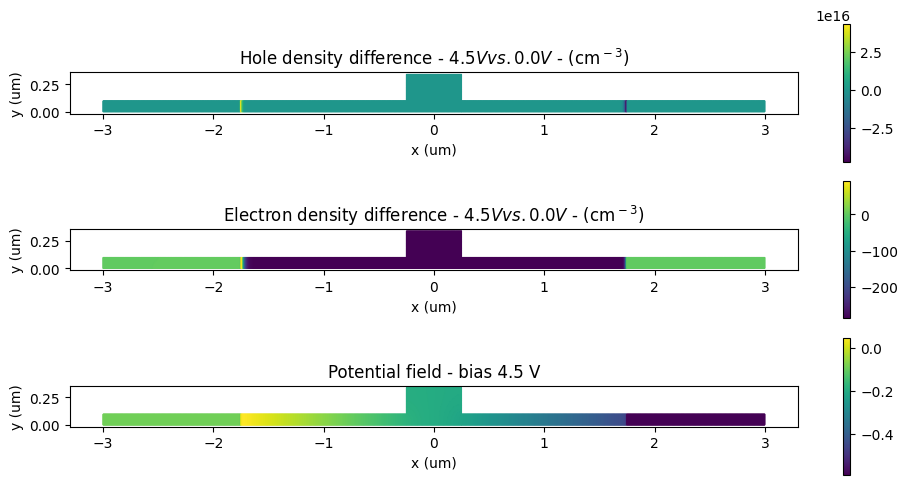

In [6]:
_, ax = plt.subplots(3, 1, figsize=(10, 5))

for ind, (volt, electrons, holes) in enumerate([carrier_data[0], carrier_data[-1]]):
    ax[ind].set_title(f"Hole density (cm$^-$$^3$) - bias: {volt:1.1f} V")
    ax[ind].set_xlabel("x (um)")
    ax[ind].set_ylabel("y (um)")

holes_diff = holes_data[-1] - holes_data[0]
electrons_diff = electrons_data[-1] - electrons_data[0]

holes_diff.plot(grid=False, ax=ax[0])
ax[0].set_title(f"Hole density difference - ${voltages[-1]}V vs. {voltages[0]}V$ - (cm$^-$$^3$)")

electrons_diff.plot(grid=False, ax=ax[1])
ax[1].set_title(f"Electron density difference - ${voltages[-1]}V vs. {voltages[0]}V$ - (cm$^-$$^3$)")

for ind in range(2):
    ax[ind].set_xlabel("x (um)")
    ax[ind].set_ylabel("y (um)")

ax[2] = potentialField[1].plot(grid=False, ax=ax[2])
ax[2].set_title(f"Potential field - bias {volt:1.1f} V")
ax[2].set_xlabel("x (um)")
ax[2].set_ylabel("y (um)")

plt.tight_layout()
plt.show()

Further, let's plot current for each applied voltage

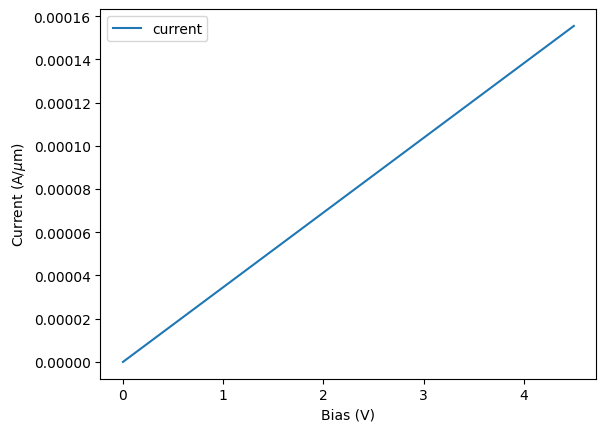

In [7]:
# let's plot the current as a function of the applied voltages
_, ax = plt.subplots(1,1)
ax.plot(voltages,currents, label="current")
ax.set_xlabel("Bias (V)")
ax.set_ylabel("Current (A/$\mu$m)")
ax.legend()
plt.show()

## Scene creation

Now that we have currents and carrier distributions for the waveguide we can start building the rest of the domain for heat and optics calculations. The waveguide is embedded in a silica cladding with the following dimensions:

In [8]:
# cladding dimensions (um)
heat_sim_width = 15 
h_cladding = 2.8  # thickness of cladding
h_box = 2  # thickness of buried oxide

# define center of the cladding so that the device sits 2um above 
center_cladding = (0, h_cladding/2, 0)
center_box = (0, -h_box/2, 0)
center_heat_sim = (0, (h_cladding-h_box)/2, 0)

For the heat mesh we can define a minimum and maximum size of the elements. Here we use the variables `dl_min` and `dl_max` for that. 
Additionally, since heat solver is 3D we will need to define some thickness in the $z$ direction. We will use `dl_min` as the thickness in that direction.

In [9]:
# heat solver mesh parameters
dl_min = h_slab / 3
dl_max = 4 * dl_min

Next we create the materials to be used. This is done through the functions `Medium()` and `PerturbationMedium()` of Tidy3D. The former is used for media with constant properties whereas we use the latter for materials with varying properties. In particular, the permittivity of Si will change with charge and temperature; and the permittivity of SiO2 will only vary with temperature.
It should be noted that a linear variation with temperature is considered, i.e., the temperature dependence of permittivity with temperature has been linearlized at the given reference temperature.
In this example we have encapsulated the material creation in the following function:

In [10]:
def create_Si_and_SiO2(wvl_ref, Tref):
    freq0 = td.C_0 / wvl_ref

    # charge perturbation parameters
    library_si = td.material_library['cSi']['Li1993_293K']
    n_si, k_si = library_si.nk_model(frequency=td.C_0/np.array(wvl_ref))

    # convert to permittivity and conductivity
    permittivity_si, conductivity_si = td.Medium.nk_to_eps_sigma(n=n_si, k=k_si, freq=freq0) 

    # Empiric relationships presented in M. Nedeljkovic, R. Soref 
    # and G. Z. Mashanovich, "Free-Carrier Electrorefraction and 
    # Electroabsorption Modulation Predictions for Silicon Over the 
    #1–14- μm Infrared Wavelength Range," IEEE Photonics Journal, 
    #vol. 3, no. 6, pp. 1171-1180, Dec. 2011

    ne_coeff = -1.91e-21
    ne_pow = 0.992

    nh_coeff = -2.28e-18
    nh_pow = 0.841

    k_factor = wvl_ref * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

    ke_coeff = k_factor * 3.22e-20
    ke_pow = 1.149

    kh_coeff = k_factor * 6.21e-20
    kh_pow = 1.119

    Ne_range = np.concatenate(([0], np.logspace(15, 20, 20)))
    Nh_range = np.concatenate(([0], np.logspace(15, 20, 21)))

    Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

    n_mesh = n_si + ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
    k_mesh = k_si + ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

    eps_mesh, sigma_mesh = td.Medium.nk_to_eps_sigma(n=n_mesh, k=k_mesh, freq=freq0)

    deps_data = td.ChargeDataArray(eps_mesh - permittivity_si, coords=dict(n=Ne_range, p=Nh_range))
    dsigma_data = td.ChargeDataArray(sigma_mesh - conductivity_si, coords=dict(n=Ne_range, p=Nh_range))

    permittivity_si_charge = td.CustomChargePerturbation(perturbation_values=deps_data)
    conductivity_si_charge = td.CustomChargePerturbation(perturbation_values=dsigma_data)

    conductivity_si_perturbation = td.ParameterPerturbation(
        charge=conductivity_si_charge,
    )


    # thermal properties
    Si_n_slope = 1.76e-4  # Si thermo-optic coefficient dn/dT, 1/K
    Si_eps_slope = 2 * n_si * Si_n_slope

    # https://www.efunda.com/materials/elements/TC_Table.cfm?Element_ID=Si
    # https://www.periodic-table.org/silicon-specific-heat/
    Si_k = 148e-6  # Si thermal conductivity, W / (um * K)
    Si_s = 0.71 * 2.33e-12  # Si volumetric heat capacity, J / (um^3 * K)

    heat_change = td.LinearHeatPerturbation(coeff=Si_eps_slope, temperature_ref=Tref)

    Si = td.PerturbationMedium(
        permittivity=permittivity_si,
        conductivity=conductivity_si,
        permittivity_perturbation=td.ParameterPerturbation(
            charge=permittivity_si_charge,
            heat=heat_change
        ),
        conductivity_perturbation=conductivity_si_perturbation,
        heat_spec=td.SolidSpec(
            conductivity=Si_k,
            capacity=Si_s,
        ),
        name="Si"
    )

    # create thermally varying SiO2
    SiO2_n = 1.444  # SiO2 refraction index
    SiO2_n_slope = 1e-5  # SiO2 thermo-optic coefficient dn/dT, 1/K

    # https://www.azom.com/properties.aspx?ArticleID=1114
    SiO2_k = 1.38e-6  # SiO2 thermal conductivity, W/(um*K)
    SiO2_s = 0.709 * 2.203e-12  # SiO2 volumetric heat capacity, J / (um^3 * K)

    # convert refraction indices to permittivity values (epsilon)
    SiO2_eps = SiO2_n**2
    SiO2_eps_slope = 2 * SiO2_n * SiO2_n_slope

    SiO2 = td.PerturbationMedium(
        permittivity=SiO2_eps,
        permittivity_perturbation=td.ParameterPerturbation(
            heat=td.LinearHeatPerturbation(coeff=SiO2_eps_slope, temperature_ref=Tref)
        ),
        heat_spec=td.SolidSpec(
            conductivity=SiO2_k,
            capacity=SiO2_s,
        ),
        name="SiO2",
    )

    return Si, SiO2

Note that since the permittivity of the material is a function of wave frequency, we require a reference wavelength. A reference temperature must also be given for the same reason.

In [11]:
# create materials with thermal and charge perturbations
wvl_si_data = 2
Tref = 300

Si, SiO2 = create_Si_and_SiO2(wvl_si_data, Tref)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

Both for heat and optics computation we create our waveguide as a list of structures as follows:

In [12]:
# create objects for heat simulation 
cladding = td.Structure(
    geometry=td.Box(center=center_heat_sim, size=(heat_sim_width, h_cladding+h_box, td.inf)),
    medium=SiO2,
    name="cladding"
)

core = td.Structure(
    geometry=td.Box(center=(0, h_core/2, 0), size=(w_core, h_core, td.inf)),
    medium=Si,
    name="core"
)

left_slab = td.Structure(
    geometry=td.Box(center=(-(x_side+w_core/2)/2, h_slab/2, 0), size=(x_side-w_core/2, h_slab, td.inf)),
    medium=Si,
    name="left_slab"
)

left_side = td.Structure(
    geometry=td.Box(center=(-(x_side+x_total)/2, h_side/2, 0), size=(x_total-x_side, h_side, td.inf)),
    medium=Si,
    name="left_side"
)

right_slab = td.Structure(
    geometry=td.Box(center=((x_side+w_core/2)/2, h_slab/2, 0), size=(x_side-w_core/2, h_slab, td.inf)),
    medium=Si,
    name="right_slab"
)

right_side = td.Structure(
    geometry=td.Box(center=((x_side+x_total)/2, h_side/2, 0), size=(x_total-x_side, h_side, td.inf)),
    medium=Si,
    name="right_side"
)

substrate = td.Structure(
    geometry=td.Box(center=(0, -h_box -h_slab/2, 0), size=(heat_sim_width, h_slab, td.inf)),
    medium=Si,
    name="substrate"
)

Once we have the different structures we can create a scene and visualize it to make sure it's correct

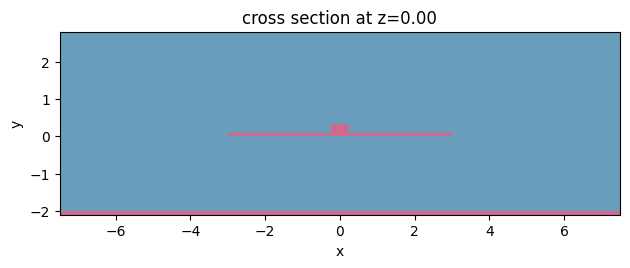

In [13]:
# create a scene with the previous structures
Si_structures = [core, left_slab, left_side, right_slab, right_side]

all_structures = [cladding, substrate] + Si_structures

scene = td.Scene(
    medium=air,
    structures=all_structures,
)

scene.plot(z=0)
plt.show()

## Heat simulation

We next create thermal boundary conditions. 
We define two BCs: a temperature BC applied to the auxiliary Si structure; and convection boundary condition applied to the interface between the mediums air and SiO2.

In [14]:
## create heat simulation

bc_air = td.HeatBoundarySpec(
    condition=td.ConvectionBC(ambient_temperature=300, transfer_coeff=10 * 1e-12),
    placement=td.MediumMediumInterface(mediums=[air.name, SiO2.name])
)

bc_substrate = td.HeatBoundarySpec(
  condition= td.TemperatureBC(temperature=300),
  placement= td.StructureStructureInterface(structures=[substrate.name, cladding.name])
)

boundary_conditions = [bc_air, bc_substrate]

Next we create a heat source. 
The total input power to the system is the electric power, computed here are $P=V\cdot i$. Remember that the electric current computed previously comes from a 2D case and, therefore, as current per unit length. We will need to multiply this current by the thickness of our domain to get the total current. 

Additionally, the heat solver takes in volumetric sources applied over a defined volume. Since we will apply the heat source over the waveguide, we will divide the total power by the volume of the waveguide.

In [15]:
# add heat source
# since we can't have a spatially varying source we'll apply an averaged value
# of the input electric power, i.e., Input_Power/device_cross_section

device_volume = (w_core*h_core + # core
    2. * (x_side-w_core/2) * h_slab + # slabs
    2. * (x_total - x_side) * h_side ) # sides
device_volume = device_volume*dl_min

input_power = voltages[1]*currents[1]*dl_min
print("Input power ", input_power * 1e3, " mW")

volumetric_heat = input_power / device_volume
print("Volumetric heat rate: ", volumetric_heat*1e3, "mW / um^3")

heat_source = td.UniformHeatSource(
    structures=[struct.name for struct in Si_structures], 
    rate=volumetric_heat
)

Input power  0.0002879570587202791  mW
Volumetric heat rate:  0.011998210780011627 mW / um^3


Next, we define a temperature monitor.
We will be able to visualize the temperature field at the monitor.

In [16]:
# set a temperature monitor
temp_mnt = td.TemperatureMonitor(center=(0,0,0), size=(td.inf, td.inf, 0), name="temperature", unstructured=True, conformal=True)


The last element we need to define before we can run the heat simulation is the mesh which we build using Tidy3D function `DistanceUnstructuredGrid()`.
We will give this function 5 arguments:
- `dl_interface`defines the grid size near the interface.
- `dl_bulk`defines the grid size away from the interface.
- `distance_interface` defines the distance from the interface until which `dl_interface` will be enforced.
- `distance_bulk`defines the distance from the interface after which `dl_bulk` will be enforced.
- `non_refined_structures` allows us to specify structures which will not be refined.


In [17]:
grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=dl_min,
    dl_bulk=dl_max,
    distance_interface=3 * dl_min,
    distance_bulk=2 * h_slab,
    non_refined_structures=[substrate.name],  # do not refine near wafer
)

At this point we can finally create the heat simulation object as well as visualize it.

The red line indicates the convection BC whereas the yellow line depicts the temperature BC. The dotted area indicates where the heat source is being applied.

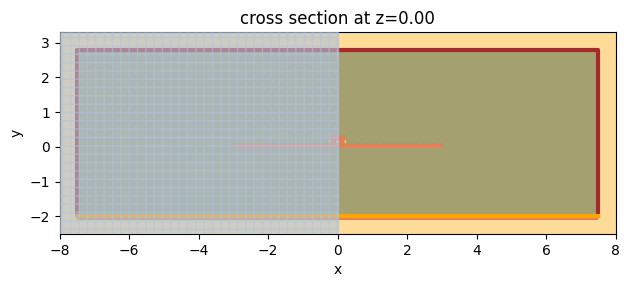

In [18]:
# build heat simulation object
heat_sim = td.HeatSimulation.from_scene(
    scene=scene,
    center=center_heat_sim,
    size=(heat_sim_width+1, h_cladding+h_box+1, dl_min),
    boundary_spec=boundary_conditions,
    sources=[heat_source],
    monitors=[temp_mnt],
    symmetry=(1, 0, 0),
    grid_spec=grid_spec,
)

heat_sim.plot(z = 0)
plt.show()

The following runs the simulation.

In [19]:
# submit the job
job = web.Job(simulation=heat_sim, task_name="heat_sim_check_mesh")
heat_sim_data = job.run()


18:32:40 CET Created task 'heat_sim_check_mesh' with task_id                    
             'he-0225e3da-db3e-40e0-a942-3d930c4579dd' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:42 CET Heat solver status: success

Output()

18:32:44 CET loading simulation from simulation_data.hdf5

Once we have the previous heat simulation we can check the mesh and the resulting temperature field. 

In the first plot we can check the thermal conductivity of the different materials. As it can be seen, silicon structures are much more conductive than the SiO2 cladding.

The last two pictures show the mesh and temperature field.

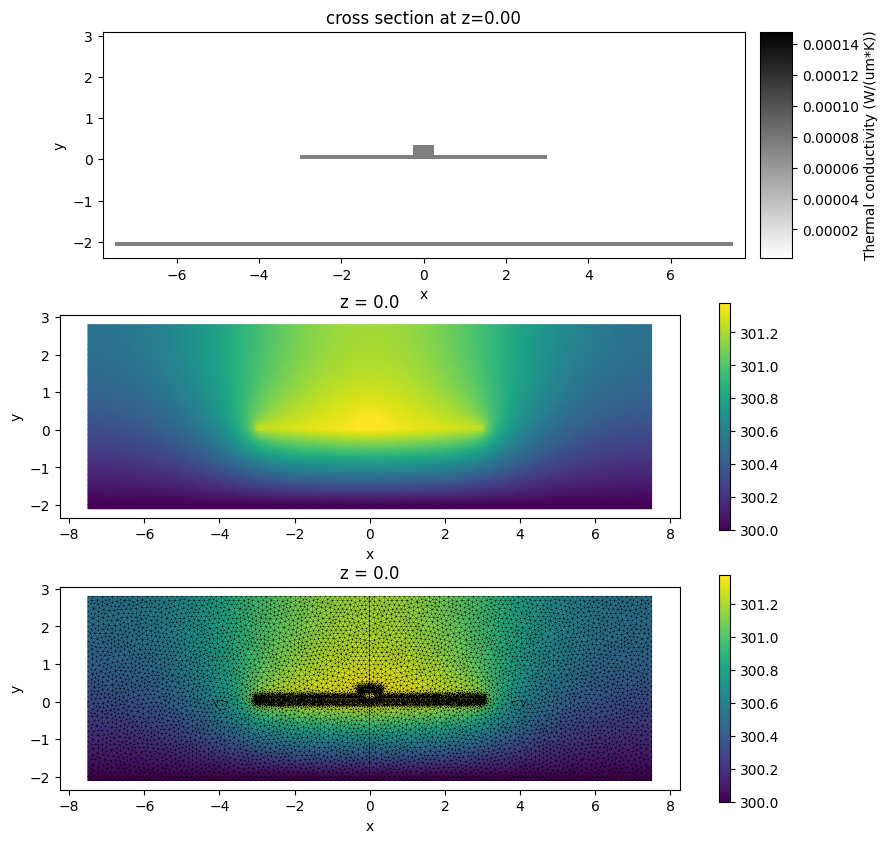

In [20]:
# let's check that the grid and temperature field makes sense
_, ax = plt.subplots(3, 1, figsize=(10, 10))

heat_sim.plot_structures_heat_conductivity(z=0, alpha=0.5, ax=ax[0])
heat_sim_data["temperature"].temperature.plot(ax=ax[1], grid=False)
heat_sim_data["temperature"].temperature.plot(ax=ax[2])
plt.show()  

Once we have made sure that the mesh and heat simulation parameters are acceptable, we can run the simulations for each voltage in the `voltages` array.
To do this we will first create a simulation object for each of the voltages:

In [21]:
# now let run it for a bunch of applied voltages
heat_simulations = {}
for n, (v,i) in enumerate(zip(voltages,currents)):
    input_power = v * i * dl_min
    volumetric_heat = input_power /device_volume
    
    # update heat sources for each structure
    heat_source = td.UniformHeatSource(
        structures=[struct.name for struct in Si_structures], 
        rate=volumetric_heat
    )
    
    # update the simulation object
    sim_name = "thermal_case_" + str(n)
    heat_simulations[sim_name] = heat_sim.updated_copy(sources=[heat_source])
    
 

In [22]:
thermal_batch_data = {}
if True: # assuming we want this to run on the server. If results are already available set this to False 
    batch = web.Batch(simulations=heat_simulations)    
    thermal_batch_data = batch.run()
    # save to file
    for i in range(len(voltages)):
        name = "thermal_case_" + str(i)
        file = "output/" + name + ".hdf5"
        thermal_batch_data[name].to_hdf5(fname=file)
else:
    # loading from file
    for i in range(len(voltages)):
        name = "thermal_case_" + str(i)
        file = "output/" + name + ".hdf5"
        thermal_batch_data[name] = td.HeatSimulationData.from_hdf5(fname=file)


18:32:45 CET Created task 'thermal_case_0' with task_id                         
             'he-f9610d65-5f49-4ab4-8cb8-9cd0b3335659' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:47 CET Created task 'thermal_case_1' with task_id                         
             'he-b06f8e01-faa6-4e05-a853-309a75c1b7e8' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:49 CET Created task 'thermal_case_2' with task_id                         
             'he-288aed9e-3da6-4255-974e-f27c37490a47' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:50 CET Created task 'thermal_case_3' with task_id                         
             'he-56923b38-2524-4f35-bb3b-25caf2518b77' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:51 CET Created task 'thermal_case_4' with task_id                         
             'he-2469ce09-4289-42d1-b735-93eee49d1e03' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:53 CET Created task 'thermal_case_5' with task_id                         
             'he-430abe71-de91-46d9-8e2a-21bbf6050679' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:55 CET Created task 'thermal_case_6' with task_id                         
             'he-516926e4-f342-4e54-a5e3-84e81b06ca80' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:56 CET Created task 'thermal_case_7' with task_id                         
             'he-274649c4-d1fc-4758-b21b-74a9017d659a' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:58 CET Created task 'thermal_case_8' with task_id                         
             'he-ceb61617-d083-4269-aad7-fea314209ddc' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:32:59 CET Created task 'thermal_case_9' with task_id                         
             'he-33711c85-32f7-4d77-b6b8-cfefac5c34a9' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

18:33:06 CET Started working on Batch.

18:33:13 CET Maximum FlexCredit cost: 0.250 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

18:33:19 CET Batch complete.

Output()

18:33:23 CET loading simulation from                                            
             ./he-f9610d65-5f49-4ab4-8cb8-9cd0b3335659.hdf5

Output()

18:33:26 CET loading simulation from                                            
             ./he-b06f8e01-faa6-4e05-a853-309a75c1b7e8.hdf5

Output()

18:33:28 CET loading simulation from                                            
             ./he-288aed9e-3da6-4255-974e-f27c37490a47.hdf5

Output()

18:33:30 CET loading simulation from                                            
             ./he-56923b38-2524-4f35-bb3b-25caf2518b77.hdf5

Output()

18:33:33 CET loading simulation from                                            
             ./he-2469ce09-4289-42d1-b735-93eee49d1e03.hdf5

Output()

18:33:35 CET loading simulation from                                            
             ./he-430abe71-de91-46d9-8e2a-21bbf6050679.hdf5

Output()

18:33:38 CET loading simulation from                                            
             ./he-516926e4-f342-4e54-a5e3-84e81b06ca80.hdf5

Output()

18:33:40 CET loading simulation from                                            
             ./he-274649c4-d1fc-4758-b21b-74a9017d659a.hdf5

Output()

18:33:42 CET loading simulation from                                            
             ./he-ceb61617-d083-4269-aad7-fea314209ddc.hdf5

Output()

18:33:44 CET loading simulation from                                            
             ./he-33711c85-32f7-4d77-b6b8-cfefac5c34a9.hdf5

Once the heat simulations have finished we can visualize a couple of them to make sure they're good:

             loading simulation from                                            
             ./he-f9610d65-5f49-4ab4-8cb8-9cd0b3335659.hdf5

18:33:45 CET loading simulation from                                            
             ./he-33711c85-32f7-4d77-b6b8-cfefac5c34a9.hdf5

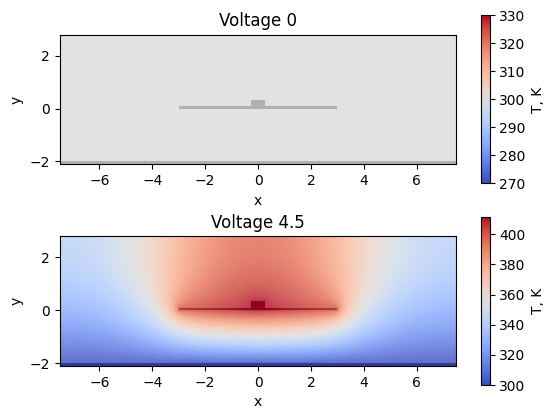

In [23]:
# plot first and last case
_, ax = plt.subplots(2,1)
thermal_batch_data["thermal_case_0"].plot_field("temperature", ax=ax[0])
thermal_batch_data[f"thermal_case_{len(voltages)-1}"].plot_field("temperature", ax=ax[1])
ax[0].set_title("Voltage 0")
ax[1].set_title(f"Voltage {voltages[-1]}")
plt.show()

## Combined Electric and Thermal Perturbations

Once we have run the heat simulations, we can apply the temperature fields obtained along with the free carrier distributions obtained previously to our optical simulations. 

As a first step we need to create a reference optics simulation:

In [24]:
# create
wvl_um = wvl_si_data
freq0 = td.C_0 / wvl_um

buffer = 1

grid_spec = td.GridSpec.auto(min_steps_per_wvl=50, wavelength=wvl_um)

optic_sim = td.Simulation.from_scene(
    scene=scene,
    center=center_heat_sim,
    size=(heat_sim_width- 2*buffer, h_cladding+h_box -2*buffer, 2.*wvl_um),
    run_time=1e-15,
    grid_spec=grid_spec,
)


             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

Now that we have the reference optical simulation we can create a list of perturbed optical simulations. We can do this like this:

In [25]:
perturbed_sims = []

target_grid = optic_sim.grid.boundaries

for n in range(len(electrons_data)):
    # deal first with temperature field
    name_thermal_data = "thermal_case_" + str(n)
    therm_data = thermal_batch_data[name_thermal_data]

    temp_interpolated = therm_data["temperature"].temperature.interp(x=target_grid.x, y=target_grid.y, z=0, fill_value=Tref)

    # now deal with charge distributions
    e_data = electrons_data[n]
    h_data = holes_data[n]
    e_interpolated = e_data.interp(x=target_grid.x, y=target_grid.y, z=0, fill_value=0)
    h_interpolated = h_data.interp(x=target_grid.x, y=target_grid.y, z=0, fill_value=0)

    perturbed_sims.append(optic_sim.perturbed_mediums_copy(
        electron_density=e_interpolated,
        hole_density=h_interpolated,
        temperature=temp_interpolated
    ))

             loading simulation from                                            
             ./he-f9610d65-5f49-4ab4-8cb8-9cd0b3335659.hdf5

18:33:46 CET WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

             loading simulation from                                            
             ./he-b06f8e01-faa6-4e05-a853-309a75c1b7e8.hdf5

             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

18:33:47 CET loading simulation from                                            
             ./he-288aed9e-3da6-4255-974e-f27c37490a47.hdf5

             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

             loading simulation from                                            
             ./he-56923b38-2524-4f35-bb3b-25caf2518b77.hdf5

18:33:48 CET WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

             loading simulation from                                            
             ./he-2469ce09-4289-42d1-b735-93eee49d1e03.hdf5

             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

18:33:49 CET loading simulation from                                            
             ./he-430abe71-de91-46d9-8e2a-21bbf6050679.hdf5

             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

             loading simulation from                                            
             ./he-516926e4-f342-4e54-a5e3-84e81b06ca80.hdf5

18:33:50 CET WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

             loading simulation from                                            
             ./he-274649c4-d1fc-4758-b21b-74a9017d659a.hdf5

             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

18:33:51 CET loading simulation from                                            
             ./he-ceb61617-d083-4269-aad7-fea314209ddc.hdf5

             WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 

             loading simulation from                                            
             ./he-33711c85-32f7-4d77-b6b8-cfefac5c34a9.hdf5

18:33:52 CET WARNING: 'simulation.structures[1]'is completely outside of        
             simulation domain.                                                 


Now that we have created the perturbed simulation we can examine the change permittivity due to these perturbations:

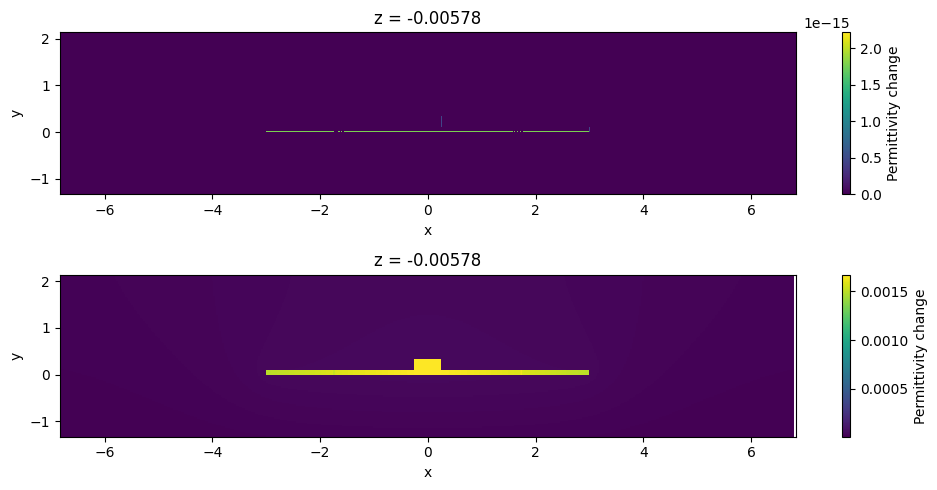

In [26]:
eps_reference = perturbed_sims[0].epsilon(box=td.Box(
    center=center_heat_sim, 
    size=(heat_sim_width, h_cladding+h_box, 0)))

_, ax = plt.subplots(2, 1, figsize=(10, 5))
for n in range(2):
    ax[n].set_xlabel("x (um)")
    ax[n].set_ylabel("y (um)")
    ax[n].set_title(f"Bias: {voltages[n]:1.1f} V")
    eps_doped = perturbed_sims[n].epsilon(box=td.Box(
        center=center_heat_sim, 
        size=(heat_sim_width, h_cladding+h_box, wvl_um))) 
    eps_doped = eps_doped.interp(x=eps_reference.x, y=eps_reference.y)
    eps_diff = np.abs(np.real(eps_doped - eps_reference))
    eps_diff.name = "Permittivity change"
    eps_diff.plot(x="x", ax=ax[n])

plt.tight_layout()
plt.show()



### Perturbation Mode Analysis

Instead of running a full wave simulation we will compute the modes of the waveguide. 
This is a smaller computation that will also highlight the influence of the temperature field over the refraction coefficient. 

We will compute the waveguide modes on a plane centered around the core section of the device:

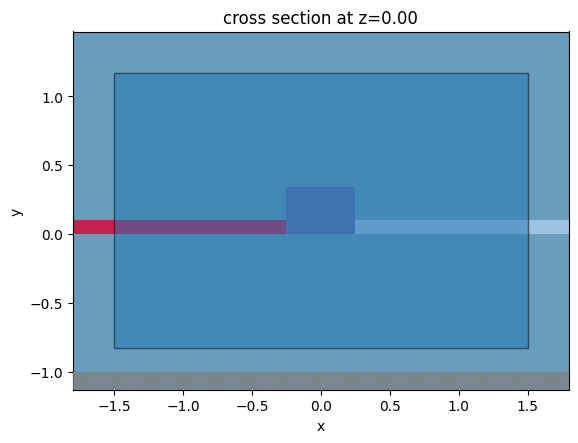

In [27]:
mode_plane = td.Box(center=(0, h_core/2, 0), size=(3, 2, 0))

fig, ax = plt.subplots(1, 1)
perturbed_sims[0].plot(z=0, ax=ax)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

The next few lines create the mode simulation objects for each of the temperature and carrier fields and submits the computation.

In [28]:
from tidy3d.plugins.mode.web import run as run_mode
from tidy3d.plugins.mode import ModeSolver

thermo_electric_mode_datas = []
mode_solvers_thermo_electric = []

for n,psim in enumerate(perturbed_sims):
    mode_solver = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
        freqs=[freq0],
    )
    mode_solvers_thermo_electric.append(mode_solver)

    name = "output/modes_thermo_electric_data_" + str(n) + ".hdf5"
    mode_solver_data = run_mode(mode_solvers_thermo_electric[n], results_file=name, reduce_simulation=True)
    thermo_electric_mode_datas.append(mode_solver_data)

18:33:55 CET Mode solver created with                                           
             task_id='fdve-8461d058-30dc-4185-a8e1-e708567f0cad',               
             solver_id='mo-00d052f0-e2b2-4d64-83e6-03d91a4040fe'.

Output()

Output()

18:33:59 CET Mode solver status: queued

18:34:01 CET Mode solver status: running

18:34:18 CET Mode solver status: success

Output()

18:34:22 CET Mode solver created with                                           
             task_id='fdve-46f74259-6f13-4f4f-b04a-3a00f7cef60b',               
             solver_id='mo-27de8613-ea3d-4c6d-8d58-292f54a13438'.

Output()

Output()

18:34:28 CET Mode solver status: queued

18:34:29 CET Mode solver status: running

18:34:43 CET Mode solver status: success

Output()

18:34:47 CET Mode solver created with                                           
             task_id='fdve-6f2fef63-5755-4b67-9f56-9964cac547a5',               
             solver_id='mo-cefbc361-2e8b-489d-a6ef-ba1e4da0e511'.

Output()

Output()

18:34:53 CET Mode solver status: queued

18:34:54 CET Mode solver status: running

18:35:06 CET Mode solver status: success

Output()

18:35:10 CET Mode solver created with                                           
             task_id='fdve-a541090b-65ba-4b08-9a99-26f3d9baba2d',               
             solver_id='mo-b42eef71-9881-456c-990b-c5b744ae0e84'.

Output()

Output()

18:35:15 CET Mode solver status: queued

18:35:16 CET Mode solver status: running

18:35:30 CET Mode solver status: success

Output()

18:35:33 CET Mode solver created with                                           
             task_id='fdve-f42f1883-91fd-4e26-a3a5-0887805aa45f',               
             solver_id='mo-87fe257d-e1dd-4a30-b0c6-9235a006b639'.

Output()

Output()

18:35:39 CET Mode solver status: queued

18:35:40 CET Mode solver status: running

18:35:53 CET Mode solver status: success

Output()

18:35:56 CET Mode solver created with                                           
             task_id='fdve-58826699-7b9b-4e1a-b24a-b3be8b2edfda',               
             solver_id='mo-22d6dc9a-c1fb-4232-9599-2e2ceed83498'.

Output()

Output()

18:36:03 CET Mode solver status: queued

18:36:04 CET Mode solver status: running

18:36:16 CET Mode solver status: success

Output()

18:36:23 CET Mode solver created with                                           
             task_id='fdve-af94f2fe-a0f9-48e8-ab16-6305085e2cf4',               
             solver_id='mo-c3dd4776-b045-4cb5-bed4-68a0f126a438'.

Output()

Output()

18:36:29 CET Mode solver status: queued

18:36:31 CET Mode solver status: running

18:36:44 CET Mode solver status: success

Output()

18:36:50 CET Mode solver created with                                           
             task_id='fdve-b149d029-e66f-48da-bdb8-6319e220dc9f',               
             solver_id='mo-e3ed0c1a-82a5-4fac-8a8f-983ac1dcc5b6'.

Output()

Output()

18:36:56 CET Mode solver status: queued

18:36:57 CET Mode solver status: running

18:37:11 CET Mode solver status: success

Output()

18:37:14 CET Mode solver created with                                           
             task_id='fdve-047eb0c7-03db-48a1-aae0-1c289587e347',               
             solver_id='mo-948d3996-5525-4a11-8bb0-d8a98c8a3a6d'.

Output()

Output()

18:37:20 CET Mode solver status: queued

18:37:42 CET Mode solver status: running

18:37:46 CET Mode solver status: success

Output()

18:37:49 CET Mode solver created with                                           
             task_id='fdve-43f49d6b-7fd0-4711-a18e-f6631797eb6d',               
             solver_id='mo-fbbb87d3-06af-48df-9a9a-ef8b2b973394'.

Output()

Output()

18:37:56 CET Mode solver status: queued

18:37:59 CET Mode solver status: running

18:38:10 CET Mode solver status: success

Output()

And finally we can see the combined effect of both thermal and carrier density on the refraction index.

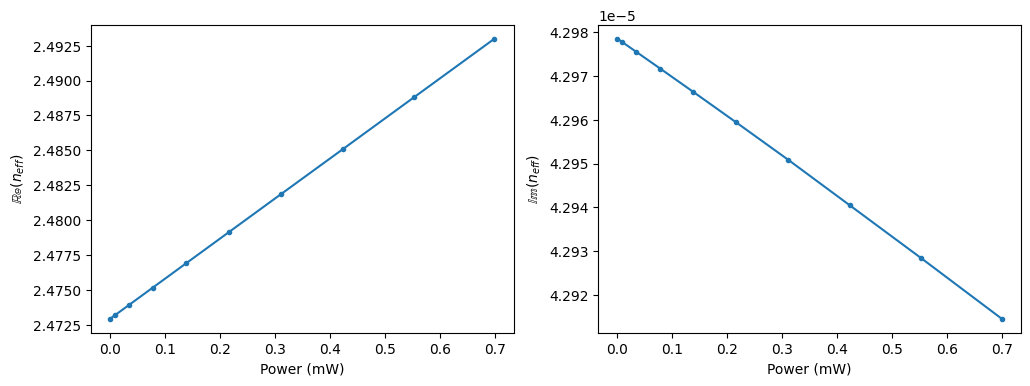

In [29]:
n_eff = np.array([md.n_complex.sel(f=freq0, mode_index=0) for md in thermo_electric_mode_datas])

inPower = np.array(voltages) * np.array(currents)

# plot n_eff
_,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(inPower*1e3, np.real(n_eff), '.-')
ax[0].set_ylabel("$\mathbb{Re}(n_{eff}$)")
ax[0].set_xlabel("Power (mW)")
ax[1].plot(inPower*1e3, np.imag(n_eff), '.-')
ax[1].set_ylabel("$\mathbb{Im}(n_{eff}$)")
ax[1].set_xlabel("Power (mW)")

plt.show()

Based on the computed refractive index we can now compute both phase shift and loss over a waveguide length of 100$\mu m$ as a function of the input (heating) power. As it can be seen, we'd need to apply a heating power of about $\approx 0.3mW$ in order to get a phase shift of $\pi$

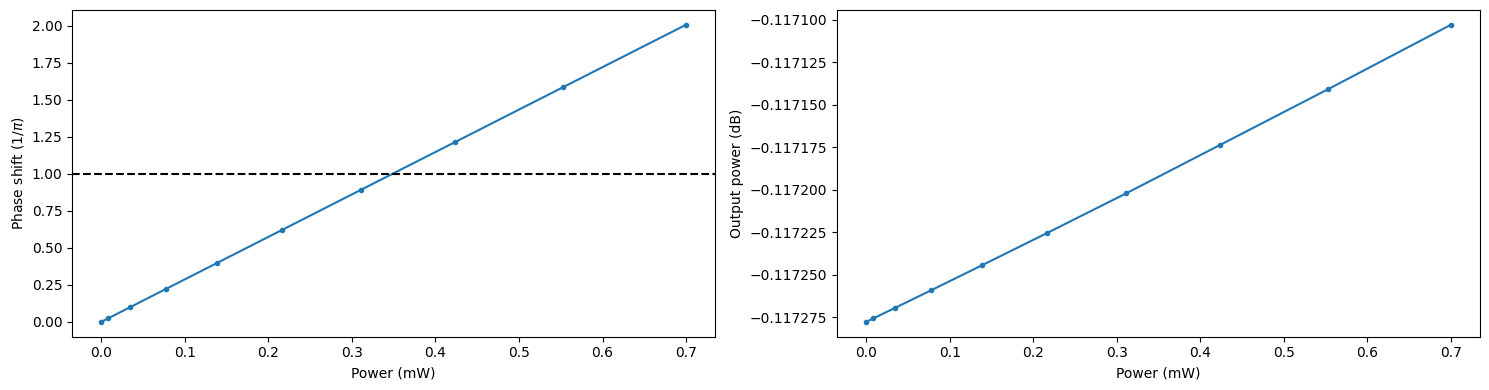

In [30]:
wvg_l = 100
phase_shift = 2 * np.pi / wvl_um * (np.real(n_eff) - np.real(n_eff[0])) * wvg_l
intensity = np.exp(-4 * np.pi * np.imag(n_eff) * wvg_l / wvl_um)

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(inPower*1e3, phase_shift / np.pi, ".-")
ax[0].axhline(y=1, color="k", linestyle="--")

ax[0].set_xlabel("Power (mW)")
ax[0].set_ylabel("Phase shift ($1/\pi$)")

ax[1].plot(inPower*1e3, 10 * np.log10(intensity), ".-")

ax[1].set_xlabel("Power (mW)")
ax[1].set_ylabel("Output power (dB)")

plt.tight_layout()
plt.show()